In [1]:
# Cell 1: Data Retrieval

# We import 3 datasets:
# 1. The NQ contract data
# 2. The Nasdaq 100 instruments
# 3. The OHLCV data for the underlying asset - to display chart

import databento as db
import os
import mplfinance as mpf
import numpy as np

api_key = os.environ.get('DATA_BENTO_API_KEY')

# The NQM4 trades between 2023-03-17 and 2024-06-21
# The Nasdaq trades on weekdays from 13:30 to 20:00 UTC
# Note: 5 minutes of data is roughly 5MB
start_time = "2024-05-31T13:30:00"
end_time = "2024-05-31T13:35:00"
# This is the CME Globex market
dataset = 'GLBX.MDP3'
# June E-mini-Nasdaq-100
symbols = ['NQM4']
# This is the NASDAQ market
underlying_dataset = 'XNAS.ITCH'
underlying_symbols = [
    "MSFT", "AAPL", "NVDA", "AMZN", "META", "AVGO", "GOOGL", "COST", "GOOG", "TSLA",
    "AMD", "NFLX", "PEP", "ADBE", "LIN", "CSCO", "TMUS", "QCOM", "INTU", "INTC",
    "CMCSA", "AMAT", "TXN", "AMGN", "ISRG", "HON", "LRCX", "BKNG", "VRTX", "MU",
    "SBUX", "REGN", "ADP", "MDLZ", "ADI", "KLAC", "GILD", "PANW", "SNPS", "PDD",
    "CDNS", "ASML", "MELI", "CRWD", "CSX", "MAR", "ABNB", "PYPL", "ORLY", "CTAS",
    "PCAR", "MNST", "NXPI", "ROP", "WDAY", "LULU", "MRVL", "ADSK", "CEG", "CPRT",
    "DASH", "FTNT", "DXCM", "ROST", "MCHP", "ODFL", "FAST", "PAYX", "IDXX", "AEP",
    "CHTR", "KHC", "GEHC", "KDP", "MRNA", "CSGP", "AZN", "DDOG", "CTSH", "TTD",
    "EXC", "EA", "FANG", "VRSK", "CDW", "BKR", "CCEP", "ON", "BIIB", "TEAM",
    "ANSS", "ZS", "XEL", "GFS", "DLTR", "MDB", "TTWO", "WBD", "ILMN", "WBA", "SIRI"
    ]
# Schema Docs - https://databento.com/docs/knowledge-base/new-users/fields-by-schema
# "Top of Book Bid and Offer"
orders_schema = "tbbo"
# "Open High Low Close Volume - 1 second"
chart_schema = "ohlcv-1s"

# Get historical or live data from Databento
client = db.Historical(api_key)

# Get the data and convert to dataframes
underlying_df = client.timeseries.get_range(
    dataset=underlying_dataset,
    symbols=underlying_symbols,
    schema=orders_schema,
    start=start_time,
    end=end_time,
).to_df()

nq_df = client.timeseries.get_range(
    dataset=dataset,
    symbols=symbols,
    schema=orders_schema,
    start=start_time,
    end=end_time,
).to_df()

nq_ohlc_df = client.timeseries.get_range(
    dataset=dataset,
    schema=chart_schema,
    symbols=symbols,
    start=start_time,
    end=end_time,
).to_df()

/tmp/ipykernel_21376/1543225366.py:48: BentoWarning: The streaming request contained one or more days which have reduced quality: 2024-05-31 (degraded). See: https://databento.com/docs/api-reference-historical/metadata/metadata-get-dataset-condition
  underlying_df = client.timeseries.get_range(


In [2]:
# Cell 2: Trade logic

from trade_utils import prepare_dataframes, group_and_aggregate, create_trades_df, modify_trades, calculate_pnl

# Add NQ bid / ask to all orders
nq_and_underlying_df = prepare_dataframes(nq_df, underlying_df)
# Group trade data in 1 second intervals
grouped_df = group_and_aggregate(nq_and_underlying_df)
# Create trades dataframe and add trades when conditions are met
trades_df = create_trades_df(grouped_df, nq_ohlc_df)
# Modify the trade dataframe to restrict to 1 contract open at a time
modify_trades(trades_df)
# Add a pnl and total_pnl column to the trades dataframe
calculate_pnl(trades_df)


In [3]:
import dtale

# Render different dataframes to see what is going on
# grouped_df
# nq_and_underlying_df
# trades_df
dtale.show(trades_df)



/home/gty/.local/lib/python3.8/site-packages/dash/_jupyter.py:28: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  _dash_comm = Comm(target_name="dash")


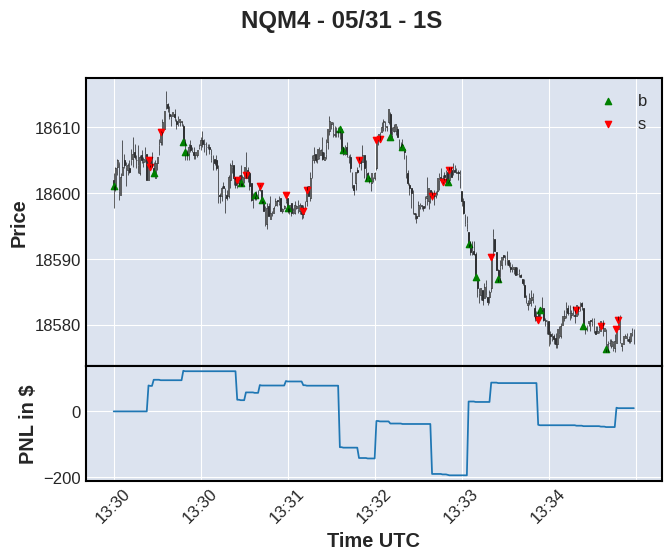

In [6]:
# # Cell 4
# # Separate the trades dataframe to plot separately (buys and sells)
# # Plot the 2 trade dataframes as scatterplots on top of ohlc data
# from chart_utils import format_chart_title

# trades_df_buys = trades_df.copy()
# # Set all rows to NaN where the 'side' is not 'B'
# trades_df_buys.loc[trades_df_buys['side'] != 'B'] = np.nan
# trades_df_buys_open = trades_df_buys.copy()
# trades_df_buys_closed = trades_df_buys.copy()

# trades_df_sells = trades_df.copy()
# # Set all rows to NaN where the 'side' is not 'B'
# trades_df_sells.loc[trades_df_sells['side'] != 'S'] = np.nan
# chart_title = format_chart_title(symbols, start_time, chart_schema)
# buy_plot = mpf.make_addplot(trades_df_buys['price'], 
#                               type='scatter', 
#                               markersize=20, 
#                               marker='^', 
#                               color='g', 
#                               label="buy")
# sell_plot = mpf.make_addplot(trades_df_sells['price'], 
#                               type='scatter', 
#                               markersize=20, 
#                               marker='v', 
#                               color='r', 
#                               label="sell")

# pnl = mpf.make_addplot(trades_df['total_pnl'],panel=1,type='line',ylabel='PNL in $')
# mpf.plot(
#     nq_ohlc_df,
#     type="candle",
#     title=chart_title,
#     ylabel="Price",
#     xlabel="Time UTC",
#     addplot=[buy_plot,sell_plot, pnl],
# )

from chart_utils import format_chart_title, create_trade_scatter, create_pnl_plot

chart_title = format_chart_title(symbols, start_time, chart_schema)
buy_plot = create_trade_scatter(trades_df, 'B', 'g', '^')
sell_plot = create_trade_scatter(trades_df, 'S', 'r', 'v')
pnl_plot = create_pnl_plot(trades_df)

mpf.plot(
    nq_ohlc_df,
    type="candle",
    title=chart_title,
    ylabel="Price",
    xlabel="Time UTC",
    addplot=[buy_plot, sell_plot, pnl_plot],
)

